In [65]:
#!pip install openpyxl
#https://clio-infra.eu/Indicators/Height.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

pd.options.mode.chained_assignment = None

df_ccode_iso = pd.read_csv('data/ccode_iso3.csv')
df_ccode_iso = df_ccode_iso[['name', 'country-code', 'alpha-3']]
df_ccode_iso.columns = ['name', 'ccode', 'iso_a3'].copy()


# load regions and equivalent country_name
df_regions_culture = pd.read_csv('data/ENS - Cultural Index - Countries Databases - consolidate_table.csv')
df_regions_culture = df_regions_culture[['region', 'iso_a3']].drop_duplicates()

# Load populatuion interpolated
df_iso = pd.read_csv('data/iso.csv', index_col = [0])
df_population_interpolated = pd.read_csv('data/population_interpolated.csv', index_col=[0])
df_population_interpolated = pd.merge(df_population_interpolated, df_iso, on = 'country_name')

df_population_region = pd.merge(df_population_interpolated, df_regions_culture, on ='iso_a3')
df_population_region['decade'] = df_population_region['year'].apply(lambda x: round(x / 10) * 10)
df_population_region = df_population_region.groupby(['region', 'decade'])['pop'].mean().reset_index()
df_population_region = df_population_region.rename(columns = {'region':'region_name'})

In [66]:
### Load CPI
path = '../3-unseen_species_index/unseen_species_model/unseen_species_model_bayesian.csv'


df_cultura = pd.read_csv(path, index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2'] # plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})


hdi_variables = [{"original_name":'HomicideRates_Compact', "new_name":"homicide_rate"},
                {"original_name":'Numeracy(Total)_Compact', "new_name":"numeracy"},
                {"original_name":'Height_Compact', "new_name":"height"},
                {"original_name":'GenderEqualityofNumeracy_Compact', "new_name":"Gender_equality_num"},
                {"original_name":'LifeExpectancyatBirth(Total)_Compact', "new_name":"life_expectancy"},
                {"original_name":'UrbanizationRatio_Compact', "new_name":"urbanization"},
                {"original_name":'CompositeMeasureofWellbeing_Compact', "new_name":"wellbeing"},
                {"original_name":'InfantMortality_Compact', "new_name":"infant_mortality"}]


# Loop over the different dimensions of the Human Development

population = False
final_tables = []

### Study the distribution


===== Analyzing homicide_rate =====


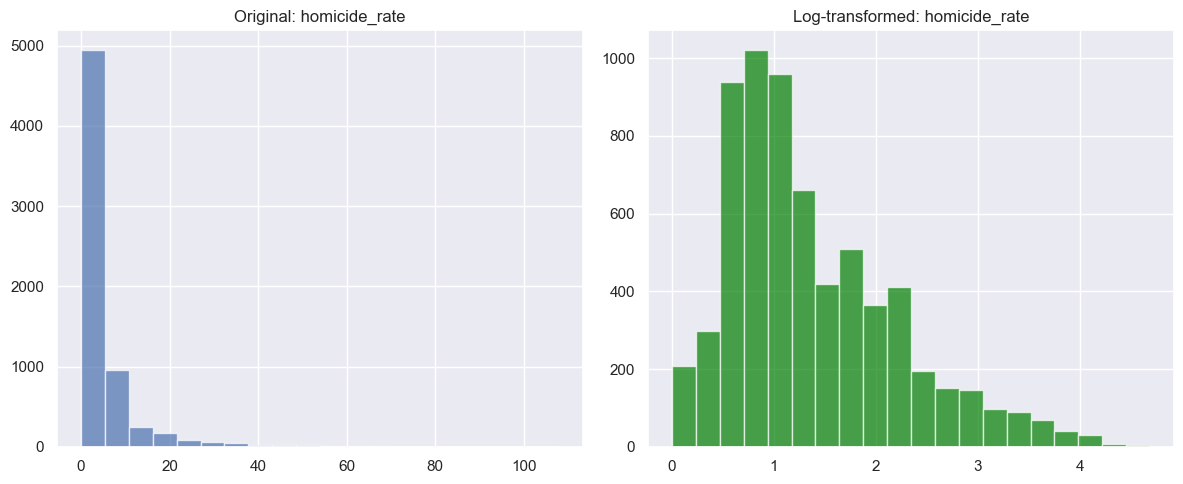

Original data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = 4.17453 (Highly skewed)

Log-transformed data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = 0.97075 (Moderately skewed)

➡️ RECOMMENDATION: Apply log transformation to homicide_rate

===== Analyzing numeracy =====


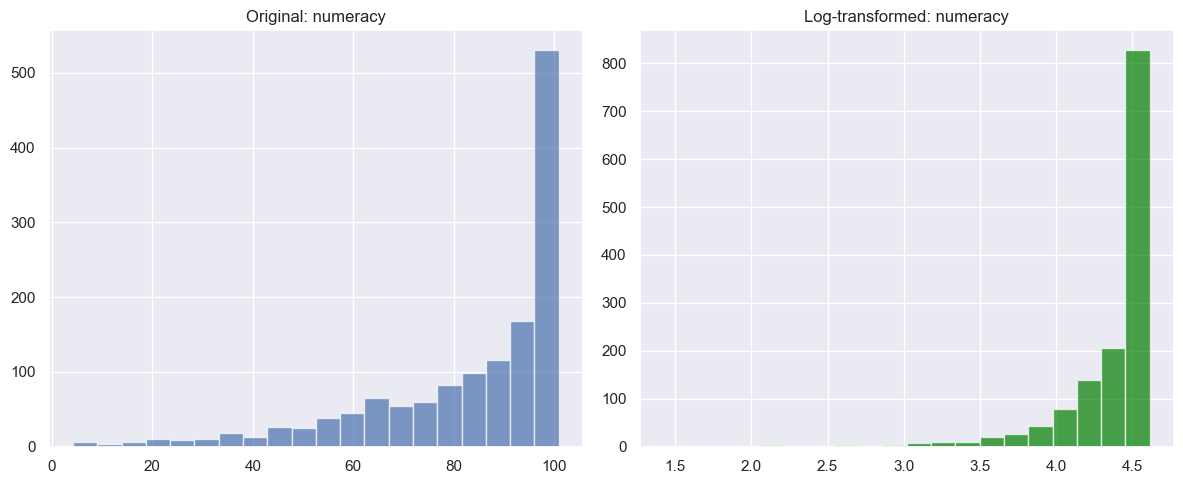

Original data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = -1.47517 (Highly skewed)

Log-transformed data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = -3.28525 (Highly skewed)

✓ No log transformation needed for numeracy

===== Analyzing height =====


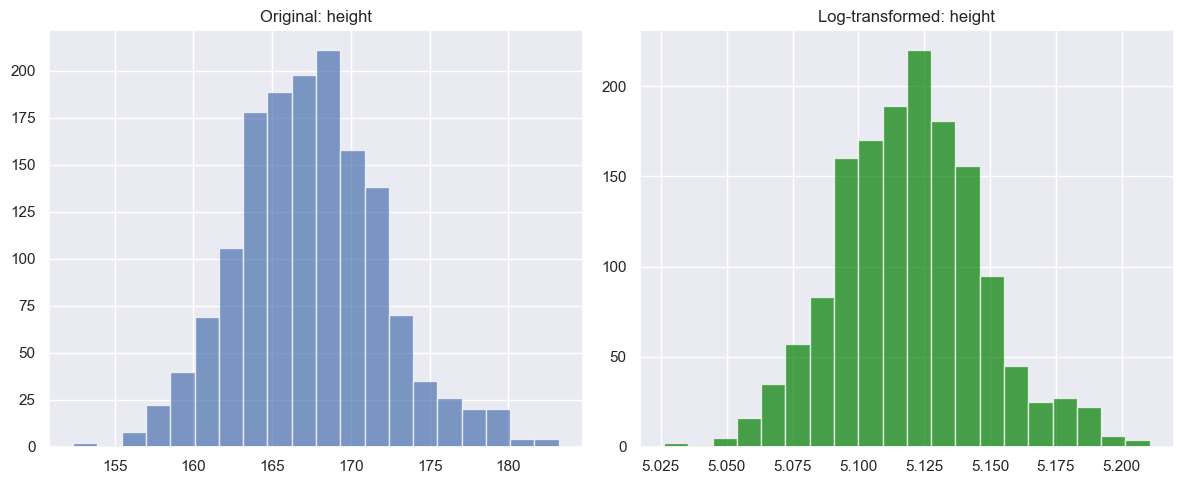

Original data:
  Shapiro-Wilk test: p-value = 0.00001 (NOT normal)
  Skewness = 0.26049 (Symmetric)

Log-transformed data:
  Shapiro-Wilk test: p-value = 0.00039 (NOT normal)
  Skewness = 0.16790 (Symmetric)

➡️ RECOMMENDATION: Apply log transformation to height

===== Analyzing Gender_equality_num =====


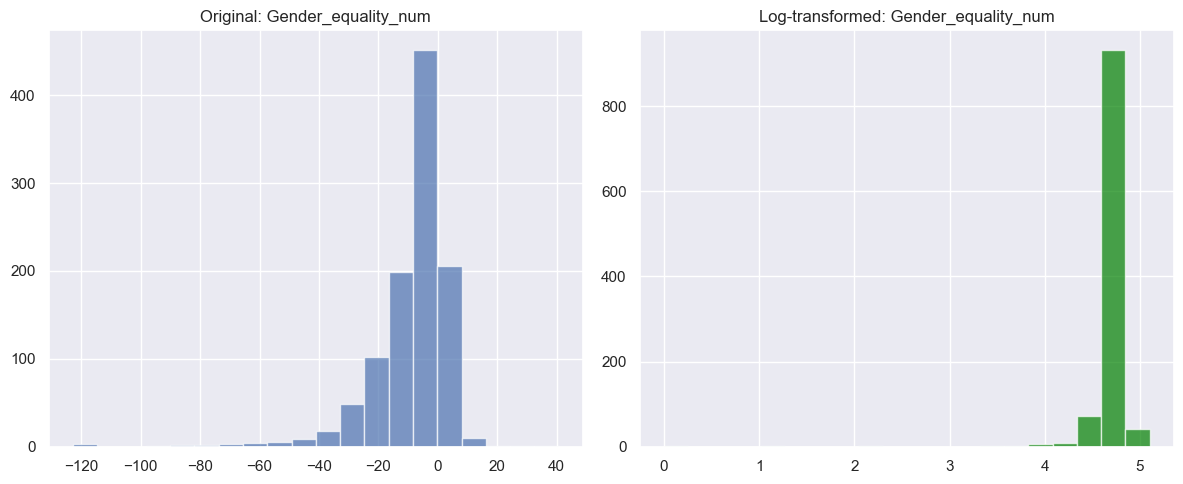

Original data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = -3.01309 (Highly skewed)

Log-transformed data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = -12.31076 (Highly skewed)

✓ No log transformation needed for Gender_equality_num

===== Analyzing life_expectancy =====


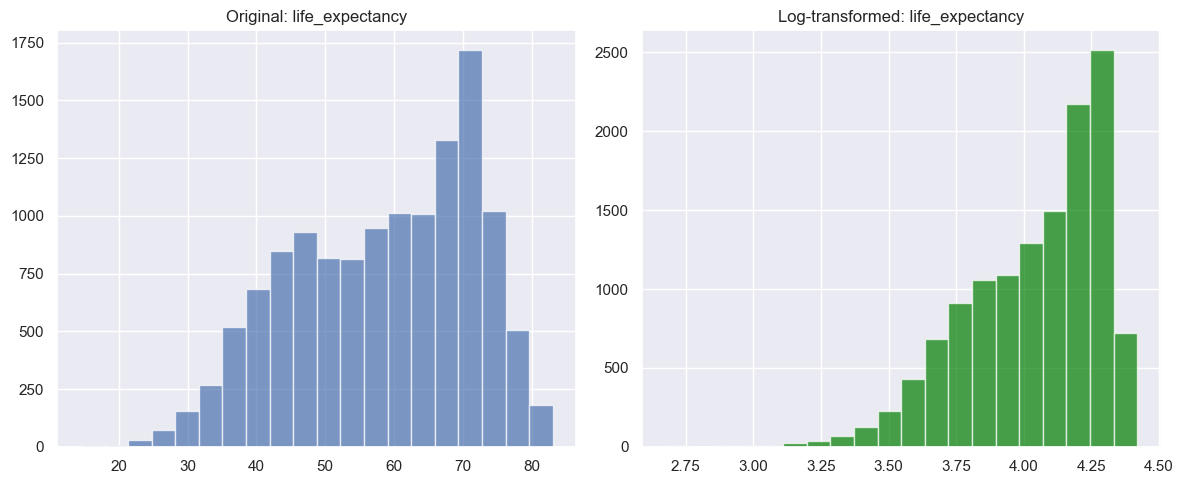

Original data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = -0.38615 (Symmetric)

Log-transformed data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = -0.87576 (Moderately skewed)

✓ No log transformation needed for life_expectancy

===== Analyzing urbanization =====


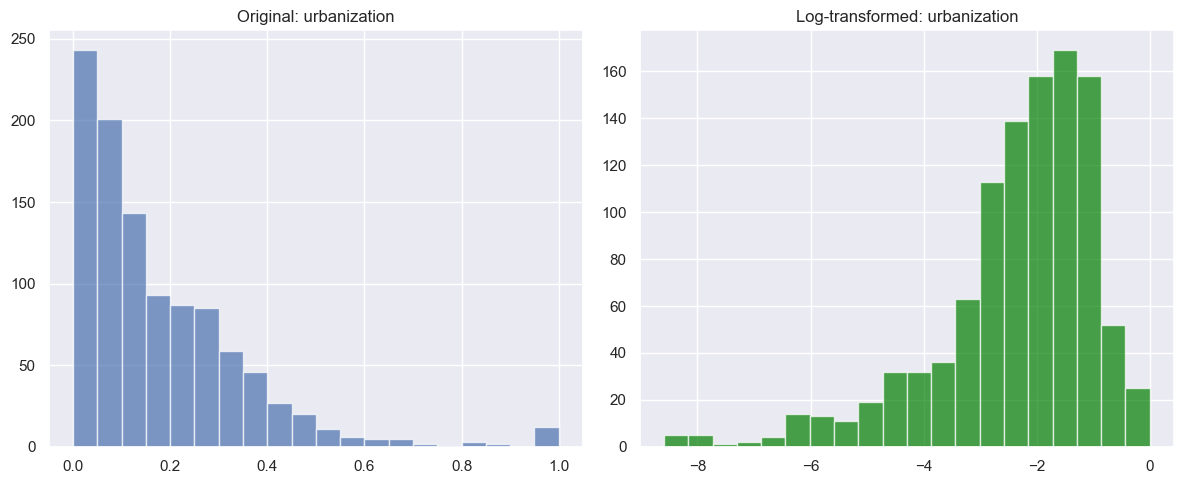

Original data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = 1.91774 (Highly skewed)

Log-transformed data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = -1.39427 (Highly skewed)

➡️ RECOMMENDATION: Apply log transformation to urbanization

===== Analyzing wellbeing =====


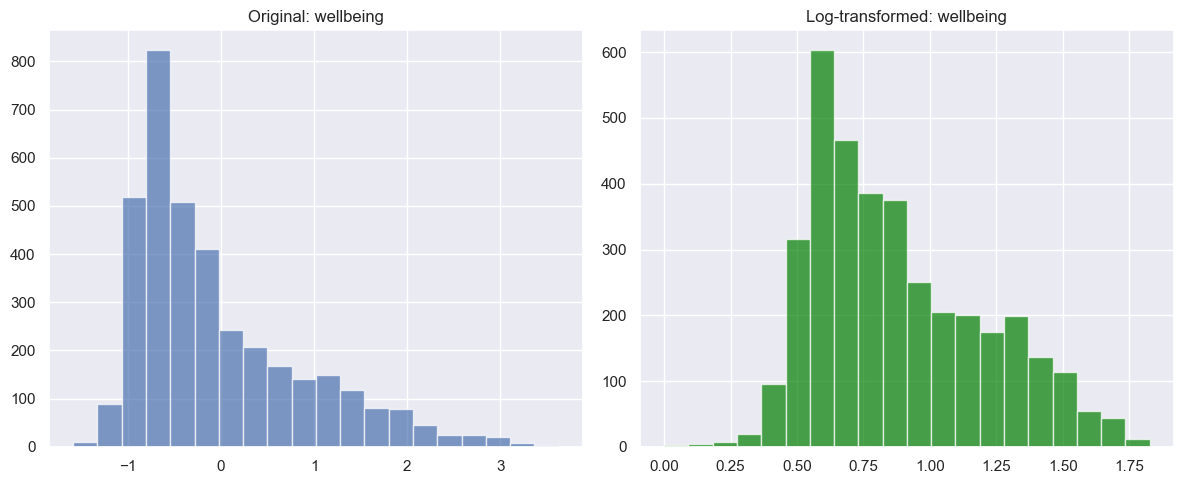

Original data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = 1.24137 (Highly skewed)

Log-transformed data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = 0.64925 (Moderately skewed)

➡️ RECOMMENDATION: Apply log transformation to wellbeing

===== Analyzing infant_mortality =====


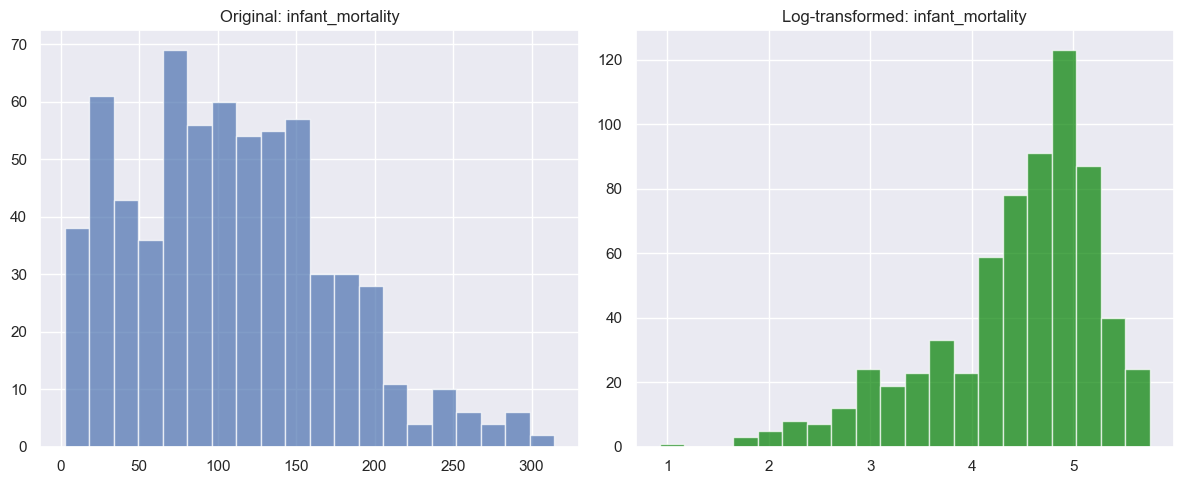

Original data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = 0.54950 (Moderately skewed)

Log-transformed data:
  Shapiro-Wilk test: p-value = 0.00000 (NOT normal)
  Skewness = -1.10987 (Highly skewed)

✓ No log transformation needed for infant_mortality


LOG TRANSFORMATION DICTIONARY:
{'homicide_rate': True, 'numeracy': False, 'height': True, 'Gender_equality_num': False, 'life_expectancy': False, 'urbanization': True, 'wellbeing': True, 'infant_mortality': False}


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Dictionary to store log transformation decisions
log_transform_dict = {}

for hdi_dict in hdi_variables:
    original_name = hdi_dict['original_name']
    var = hdi_dict['new_name']

    print(f"\n===== Analyzing {var} =====")

    df_var = pd.read_excel(f'data/environment_data/{original_name}.xlsx', sheet_name='Data Long Format')
    df_var = df_var.rename(columns={'value':var, 'country.name':'name'})
    df_var = df_var.sort_values(var, ascending=False)
    
    # Remove missing values for analysis
    data = df_var[var].dropna()
    
    # Skip if too few data points
    if len(data) < 8:
        print(f"Too few data points for {var}")
        log_transform_dict[var] = False
        continue
        
    # Statistical test for normality (Shapiro-Wilk test)
    stat, p_value = stats.shapiro(data)
    is_normal = p_value > 0.05
    
    # Calculate skewness
    skewness = stats.skew(data)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original distribution
    ax1.hist(data, bins=20, alpha=0.7)
    ax1.set_title(f'Original: {var}')
    
    # Log transformation (handling zeros/negatives)
    if data.min() <= 0:
        log_data = np.log(data - data.min() + 1)  # log(x+1) after shifting
    else:
        log_data = np.log(data)
    
    # Log-transformed distribution
    ax2.hist(log_data, bins=20, alpha=0.7, color='green')
    ax2.set_title(f'Log-transformed: {var}')
    
    plt.tight_layout()
    plt.show()
    
    # Shapiro-Wilk test on log-transformed data
    log_stat, log_p_value = stats.shapiro(log_data)
    log_is_normal = log_p_value > 0.05
    
    # Check skewness of log-transformed data
    log_skewness = stats.skew(log_data)
    
    # Print results
    print(f"Original data:")
    print(f"  Shapiro-Wilk test: p-value = {p_value:.5f} ({'Normal' if is_normal else 'NOT normal'})")
    print(f"  Skewness = {skewness:.5f} ({'Symmetric' if abs(skewness) < 0.5 else 'Moderately skewed' if abs(skewness) < 1 else 'Highly skewed'})")
    print(f"\nLog-transformed data:")
    print(f"  Shapiro-Wilk test: p-value = {log_p_value:.5f} ({'Normal' if log_is_normal else 'NOT normal'})")
    print(f"  Skewness = {log_skewness:.5f} ({'Symmetric' if abs(log_skewness) < 0.5 else 'Moderately skewed' if abs(log_skewness) < 1 else 'Highly skewed'})")
    
    # Final recommendation
    needs_log = not is_normal and (log_is_normal or abs(log_skewness) < abs(skewness))
    
    if needs_log:
        print(f"\n➡️ RECOMMENDATION: Apply log transformation to {var}")
    else:
        print(f"\n✓ No log transformation needed for {var}")
        
    # Store decision in dictionary
    log_transform_dict[var] = needs_log

# Print the resulting dictionary
print("\n\n=============================================")
print("LOG TRANSFORMATION DICTIONARY:")
print("=============================================")
print(log_transform_dict)

In [68]:
# log_transform_dict['height'] = False

HomicideRates_Compact
Numeracy(Total)_Compact
Height_Compact
GenderEqualityofNumeracy_Compact
LifeExpectancyatBirth(Total)_Compact
UrbanizationRatio_Compact
CompositeMeasureofWellbeing_Compact
InfantMortality_Compact


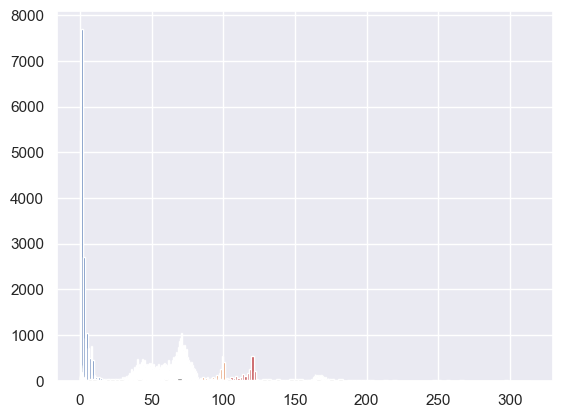

In [69]:

for hdi_dict in hdi_variables:

    # hdi_dict = hdi_variables[1]

    original_name = hdi_dict['original_name']
    var =  hdi_dict['new_name']

    print(original_name)

    df_var = pd.read_excel(f'data/environment_data/{original_name}.xlsx', sheet_name='Data Long Format')
    df_var = df_var.rename(columns={'value':var, 'country.name':'name'})
    df_var = df_var.sort_values(var, ascending=False)
    df_var = df_var.drop('name', axis=1)


    df_var = pd.merge(df_var, df_ccode_iso, on = 'ccode')
    df_var = pd.merge(df_var, df_regions_culture, on = 'iso_a3')
    df_var = df_var.rename(columns={'name':'country_name'})


    # Make sure there are no negative values

    negative_values = ['CompositeMeasureofWellbeing_Compact', 'GenderEqualityofNumeracy_Compact']

    if original_name in negative_values:
        df_var[var]=df_var[var] + abs(min(df_var[var]))

    df_var[var].hist(bins=100)
    # plt.show()

    # Weight the values by population to properly represent regions that contain multiple aggregated countries.RetryClaude can make mistakes. Please double-check responses.
    var_weighted = f'{var}_weighted'
    df_var_pop = pd.merge(df_var, df_population_interpolated, on = ['year','iso_a3'])

    df_var_w = df_var_pop.groupby(['region', 'year']).apply(lambda x: (x[var] * x['pop']).sum() / x['pop'].sum())
    df_var_w = df_var_w.reset_index()
    df_var_w = df_var_w.rename(columns={0: var_weighted})


    df_var_w = df_var_w[df_var_w['year']<=1880]
    df_var_w['decade'] = df_var_w['year'].apply(lambda x: round(x / 10) * 10)

    # now, make the mean for every decade
    df_var_w = df_var_w.groupby(['region', 'decade'])[var_weighted].mean().reset_index()
    df_var_w = df_var_w.rename(columns={"region": "region_name"})


    #df_pop_w =  df_var_w.groupby(['region', 'decade'])['pop'].mean().reset_index()
    # df_var_w.to_csv('other_data/f{var}_weighted_pop_decade.csv')

    df = pd.merge(df_var_w, df_cultura, on = ['region_name', 'decade'])
    df = pd.merge(df, df_population_region, on = ['region_name', 'decade'])
    df = df.rename(columns = {'decade': 'year'})

    keep = ['Indian world',
    'Nordic countries',
    'Persian world',
    'Portugal',
    'United Kingdom',
    'France',
    'Greek World',
    'Arabic world',
    'Chinese world',
    'Japan',
    'German world',
    'Low countries',
    'Italy',
    'Korea',
    'Spain']



    from scipy import stats  # Import for using zscore function

        # Calculate century from year
    df["century"] = df["year"].round(-2)

    # Score calculations
    df["score_log"] = np.log(df["score"])
    df["score_log_std"] = stats.zscore(df["score_log"])  # Z-score instead of division

    # N_est calculations
    df["N_est_log"] = np.log(df["N_est"])
    df["N_est_std"] = stats.zscore(df["N_est"])  # Z-score 
    df["N_est_log_std"] = stats.zscore(df["N_est_log"])  # Z-score

    # Variable calculations
    df[f"log_{var}"] = np.log(df[f"{var}_weighted"])
    #df[f"log_{var}_std"] = stats.zscore(df[f"log_{var}"])  # Z-score

    # HERE IS THE MAIN

    log = log_transform_dict[var]

    if log:
        df[f"log_{var}_std"] = stats.zscore(np.log(df[f"{var}_weighted"]))  # Z-score
    else:
         df[f"log_{var}_std"] = stats.zscore(df[f"{var}_weighted"]) # Z-score

    # Variable standardization and population
    # df[f"{var}_std"] = stats.zscore(df[f"{var}_weighted"])  # Z-score
    df["log_pop"] = np.log(df["pop"])
    df["log_pop_std"] = stats.zscore(df["log_pop"])  # Z-score


    df = df[df['region_name'].isin(keep)]
    df_ols = df[['region_name', 'year', f'log_{var}_std', 'N_est_log_std', f"{var}_weighted", "log_pop_std"]].copy()


    # Fit Mixed Effects Model (with region as a random effect)

    # Add population as a cofoundinf factor
    if population is True:
        mixed_model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std + log_pop_std", df_ols, groups=df_ols["region_name"])
    else:
        mixed_model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"]) #use a dataset that does not assume linear distribution
    result_mixed = mixed_model.fit()

    # Fit OLS Model (without fixed effects)
    ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", df_ols)
    result_ols = ols_model.fit()

    # Calculate the correlation coefficient for the OLS model (without fixed effects)
    correlation_ols = df_ols['N_est_log_std'].corr(df_ols[f"log_{var}_std"])

    # Calculate correlation coefficients for each group in the mixed effects model and take the average
    grouped = df_ols.groupby('region_name')
    correlation_mixed = grouped.apply(lambda g: g['N_est_log_std'].corr(g[f"log_{var}_std"])).mean()

    # Prepare the results dataframe
    results_df = pd.DataFrame({
        'Model': ['OLS Without FE', 'MixedLM With FE'],
        'Intercept': [f"{result_ols.params['Intercept']:.2f}", f"{result_mixed.params['Intercept']:.2f}"],
        'Intercept_SE': [f"{result_ols.bse['Intercept']:.2f}", f"{result_mixed.bse['Intercept']:.2f}"],
        'Intercept_CI': [f"({result_ols.conf_int().loc['Intercept'][0]:.2f}, {result_ols.conf_int().loc['Intercept'][1]:.2f})", 
                        f"({result_mixed.conf_int().loc['Intercept'][0]:.2f}, {result_mixed.conf_int().loc['Intercept'][1]:.2f})"],
        'Intercept_t-value': [f"{result_ols.tvalues['Intercept']:.2f}", f"{result_mixed.tvalues['Intercept']:.2f}"],
        'Coef': [f"{result_ols.params['N_est_log_std']:.2f}", f"{result_mixed.params['N_est_log_std']:.2f}"],
        'Coef_SE': [f"{result_ols.bse['N_est_log_std']:.2f}", f"{result_mixed.bse['N_est_log_std']:.2f}"],
        'Coef_CI': [f"({result_ols.conf_int().loc['N_est_log_std'][0]:.2f}, {result_ols.conf_int().loc['N_est_log_std'][1]:.2f})", 
                    f"({result_mixed.conf_int().loc['N_est_log_std'][0]:.2f}, {result_mixed.conf_int().loc['N_est_log_std'][1]:.2f})"],
        'Coef_t-value': [f"{result_ols.tvalues['N_est_log_std']:.2f}", f"{result_mixed.tvalues['N_est_log_std']:.2f}"],
        'Coef_p-value': [f"{result_ols.pvalues['N_est_log_std']:.3f}", f"{result_mixed.pvalues['N_est_log_std']:.3f}"],
        'Log-Likelihood': [f"{result_ols.llf:.2f}", f"{result_mixed.llf:.2f}"],
        'Correlation': [f"{correlation_ols:.2f}", f"{correlation_mixed:.2f}"],
        'N': [f"{result_ols.nobs:.0f}", f"{result_mixed.nobs:.0f}"],
        'R-squared': [f"{result_ols.rsquared:.2f}", "N/A"]
    })

    # Transpose the DataFrame for the desired format and add variable name
    results_df = results_df.T
    results_df.columns = results_df.iloc[0]  # Set the first row as column headers
    results_df = results_df[1:]  # Remove the first row as it's now redundant
    results_df['Variable'] = var

    # Save the results to a CSV file
    #results_df.to_csv(f'df_indicators_hdi/regression_table_{var}.csv')

    final_tables.append(results_df)

# Consolidate the table
data = pd.concat([x for x in final_tables])
data = data.reset_index()
data = data.rename(columns = {'index':'measure'})
list(set(data['measure']))

data = data.sort_values(['Variable', 'measure'])

if population is False:
    data.to_csv('data/hdi_table.csv')
else:
     data.to_csv('data/hdi_table_population.csv')


## Check per variable

InfantMortality_Compact


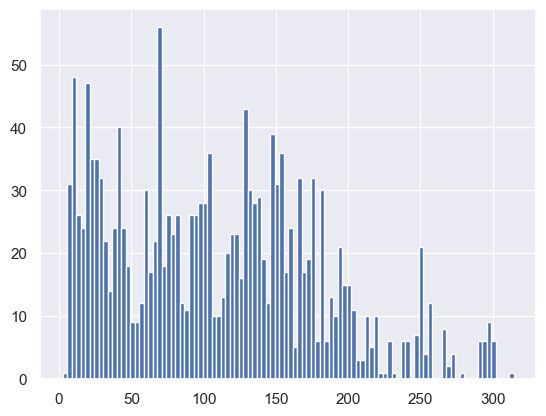

In [70]:
hdi_variables = [{"original_name":'UrbanizationRatio_Compact', "new_name":"urbanization"}]


hdi_variables = [{"original_name":'HomicideRates_Compact', "new_name":"homicide_rate"},
                {"original_name":'Numeracy(Total)_Compact', "new_name":"numeracy"},
                {"original_name":'Height_Compact', "new_name":"height"},
                {"original_name":'GenderEqualityofNumeracy_Compact', "new_name":"Gender_equality_num"},
                {"original_name":'LifeExpectancyatBirth(Total)_Compact', "new_name":"life_expectancy"},
                {"original_name":'UrbanizationRatio_Compact', "new_name":"urbanization"},
                {"original_name":'CompositeMeasureofWellbeing_Compact', "new_name":"wellbeing"},
                {"original_name":'InfantMortality_Compact', "new_name":"infant_mortality"}]


hdi_variables = [hdi_variables[7]]
hdi_variables



for hdi_dict in hdi_variables:

    # hdi_dict = hdi_variables[1]

    original_name = hdi_dict['original_name']
    var =  hdi_dict['new_name']

    print(original_name)

    df_var = pd.read_excel(f'data/environment_data/{original_name}.xlsx', sheet_name='Data Long Format')
    df_var = df_var.rename(columns={'value':var, 'country.name':'name'})
    df_var = df_var.sort_values(var, ascending=False)
    df_var = df_var.drop('name', axis=1)


    df_var = pd.merge(df_var, df_ccode_iso, on = 'ccode')
    df_var = pd.merge(df_var, df_regions_culture, on = 'iso_a3')
    df_var = df_var.rename(columns={'name':'country_name'})


    # Make sure there are no negative values

    negative_values = ['CompositeMeasureofWellbeing_Compact', 'GenderEqualityofNumeracy_Compact']

    if original_name in negative_values:
        df_var[f"initial_{var}"] = df_var[var]
        df_var[var]=df_var[var] + abs(min(df_var[var])) + 0.00000001

    df_var[var].hist(bins=100)
    # plt.show()

    # Weight the values by population to properly represent regions that contain multiple aggregated countries.RetryClaude can make mistakes. Please double-check responses.
    var_weighted = f'{var}_weighted'
    df_var_pop = pd.merge(df_var, df_population_interpolated, on = ['year','iso_a3'])

    df_var_w = df_var_pop.groupby(['region', 'year']).apply(lambda x: (x[var] * x['pop']).sum() / x['pop'].sum())
    df_var_w = df_var_w.reset_index()
    df_var_w = df_var_w.rename(columns={0: var_weighted})


    df_var_w = df_var_w[df_var_w['year']<=1880]
    df_var_w['decade'] = df_var_w['year'].apply(lambda x: round(x / 10) * 10)

    # now, make the mean for every decade
    df_var_w = df_var_w.groupby(['region', 'decade'])[var_weighted].mean().reset_index()
    df_var_w = df_var_w.rename(columns={"region": "region_name"})


    #df_pop_w =  df_var_w.groupby(['region', 'decade'])['pop'].mean().reset_index()

    # df_var_w.to_csv('other_data/f{var}_weighted_pop_decade.csv')

    df = pd.merge(df_var_w, df_cultura, on = ['region_name', 'decade'])
    df = pd.merge(df, df_population_region, on = ['region_name', 'decade'])
    df = df.rename(columns = {'decade': 'year'})

    keep = ['Indian world',
    'Nordic countries',
    'Persian world',
    'Portugal',
    'United Kingdom',
    'France',
    'Greek World',
    'Arabic world',
    'Chinese world',
    'Japan',
    'German world',
    'Low countries',
    'Italy',
    'Korea',
    'Spain']

    # Apply normalization (Standard Deviation)

    # df["century"] = df["year"].round(-2)
    # df["score_log"] = np.log(df["score"])
    # df["N_est_log"] = np.log(df["N_est"])
    # df["score_log_std"] = df["score_log"] / df["score_log"].mean()
    
    
    # df["N_est_std"] = df["N_est"] / df["N_est"].mean()
    # df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()
    
    
    # df[f"log_{var}"] = np.log(df[f"{var}_weighted"])
    # df[f"log_{var}_std"] = df[f"log_{var}"] / df[f"log_{var}"].mean()


    # df[f"{var}_std"] = df[f"{var}_weighted"] / df[f"{var}_weighted"].mean()
    # df["log_pop"] =  np.log(df["pop"])
    # df["log_pop_std"] =  df["log_pop"] / df["log_pop"].mean()


    from scipy import stats  # Import for using zscore function

    # Calculate century from year
    df["century"] = df["year"].round(-2)

    # Score calculations
    df["score_log"] = np.log(df["score"])
    df["score_log_std"] = stats.zscore(df["score_log"])  # Z-score instead of division

    # N_est calculations
    df["N_est_log"] = np.log(df["N_est"])
    df["N_est_std"] = stats.zscore(df["N_est"])  # Z-score 
    df["N_est_log_std"] = stats.zscore(df["N_est_log"])  # Z-score

    # Variable calculations
    df[f"log_{var}"] = np.log(df[f"{var}_weighted"])

    # df[f"log_{var}_std"] = stats.zscore(df[f"log_{var}"])  # Z-score

    df[f"log_{var}_std"] = stats.zscore(df[f"{var}_weighted"])  # Z-score


    # Variable standardization and population
    # df[f"{var}_std"] = stats.zscore(df[f"{var}_weighted"])  # Z-score
    df["log_pop"] = np.log(df["pop"])
    df["log_pop_std"] = stats.zscore(df["log_pop"])  # Z-score


    df = df[df['region_name'].isin(keep)]
    df_ols = df[['region_name', 'year', f'log_{var}_std', 'N_est_log_std', f"{var}_weighted", "log_pop_std"]].copy()


    # Fit Mixed Effects Model (with region as a random effect)

    # Add population as a cofoundinf factor
    if population is True:
        mixed_model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std + log_pop_std", df_ols, groups=df_ols["region_name"])
    else:
        mixed_model = smf.mixedlm(f"log_{var}_std ~ N_est_log_std", df_ols, groups=df_ols["region_name"])
    result_mixed = mixed_model.fit()

    # Fit OLS Model (without fixed effects)
    ols_model = smf.ols(f"log_{var}_std ~ N_est_log_std", df_ols)
    result_ols = ols_model.fit()

    # Calculate the correlation coefficient for the OLS model (without fixed effects)
    correlation_ols = df_ols['N_est_log_std'].corr(df_ols[f"log_{var}_std"])

    # Calculate correlation coefficients for each group in the mixed effects model and take the average
    grouped = df_ols.groupby('region_name')
    correlation_mixed = grouped.apply(lambda g: g['N_est_log_std'].corr(g[f"log_{var}_std"])).mean()

    # Prepare the results dataframe
    results_df = pd.DataFrame({
        'Model': ['OLS Without FE', 'MixedLM With FE'],
        'Intercept': [f"{result_ols.params['Intercept']:.2f}", f"{result_mixed.params['Intercept']:.2f}"],
        'Intercept_SE': [f"{result_ols.bse['Intercept']:.2f}", f"{result_mixed.bse['Intercept']:.2f}"],
        'Intercept_CI': [f"({result_ols.conf_int().loc['Intercept'][0]:.2f}, {result_ols.conf_int().loc['Intercept'][1]:.2f})", 
                        f"({result_mixed.conf_int().loc['Intercept'][0]:.2f}, {result_mixed.conf_int().loc['Intercept'][1]:.2f})"],
        'Intercept_t-value': [f"{result_ols.tvalues['Intercept']:.2f}", f"{result_mixed.tvalues['Intercept']:.2f}"],
        'Coef': [f"{result_ols.params['N_est_log_std']:.2f}", f"{result_mixed.params['N_est_log_std']:.2f}"],
        'Coef_SE': [f"{result_ols.bse['N_est_log_std']:.2f}", f"{result_mixed.bse['N_est_log_std']:.2f}"],
        'Coef_CI': [f"({result_ols.conf_int().loc['N_est_log_std'][0]:.2f}, {result_ols.conf_int().loc['N_est_log_std'][1]:.2f})", 
                    f"({result_mixed.conf_int().loc['N_est_log_std'][0]:.2f}, {result_mixed.conf_int().loc['N_est_log_std'][1]:.2f})"],
        'Coef_t-value': [f"{result_ols.tvalues['N_est_log_std']:.2f}", f"{result_mixed.tvalues['N_est_log_std']:.2f}"],
        'Coef_p-value': [f"{result_ols.pvalues['N_est_log_std']:.3f}", f"{result_mixed.pvalues['N_est_log_std']:.3f}"],
        'Log-Likelihood': [f"{result_ols.llf:.2f}", f"{result_mixed.llf:.2f}"],
        'Correlation': [f"{correlation_ols:.2f}", f"{correlation_mixed:.2f}"],
        'N': [f"{result_ols.nobs:.0f}", f"{result_mixed.nobs:.0f}"],
        'R-squared': [f"{result_ols.rsquared:.2f}", "N/A"]
    })

    # Transpose the DataFrame for the desired format and add variable name
    results_df = results_df.T
    results_df.columns = results_df.iloc[0]  # Set the first row as column headers
    results_df = results_df[1:]  # Remove the first row as it's now redundant
    results_df['Variable'] = var

    # Save the results to a CSV file
    #results_df.to_csv(f'df_indicators_hdi/regression_table_{var}.csv')

    final_tables.append(results_df)

# Consolidate the table
data = pd.concat([x for x in final_tables])
data = data.reset_index()
data = data.rename(columns = {'index':'measure'})
list(set(data['measure']))

data = data.sort_values(['Variable', 'measure'])


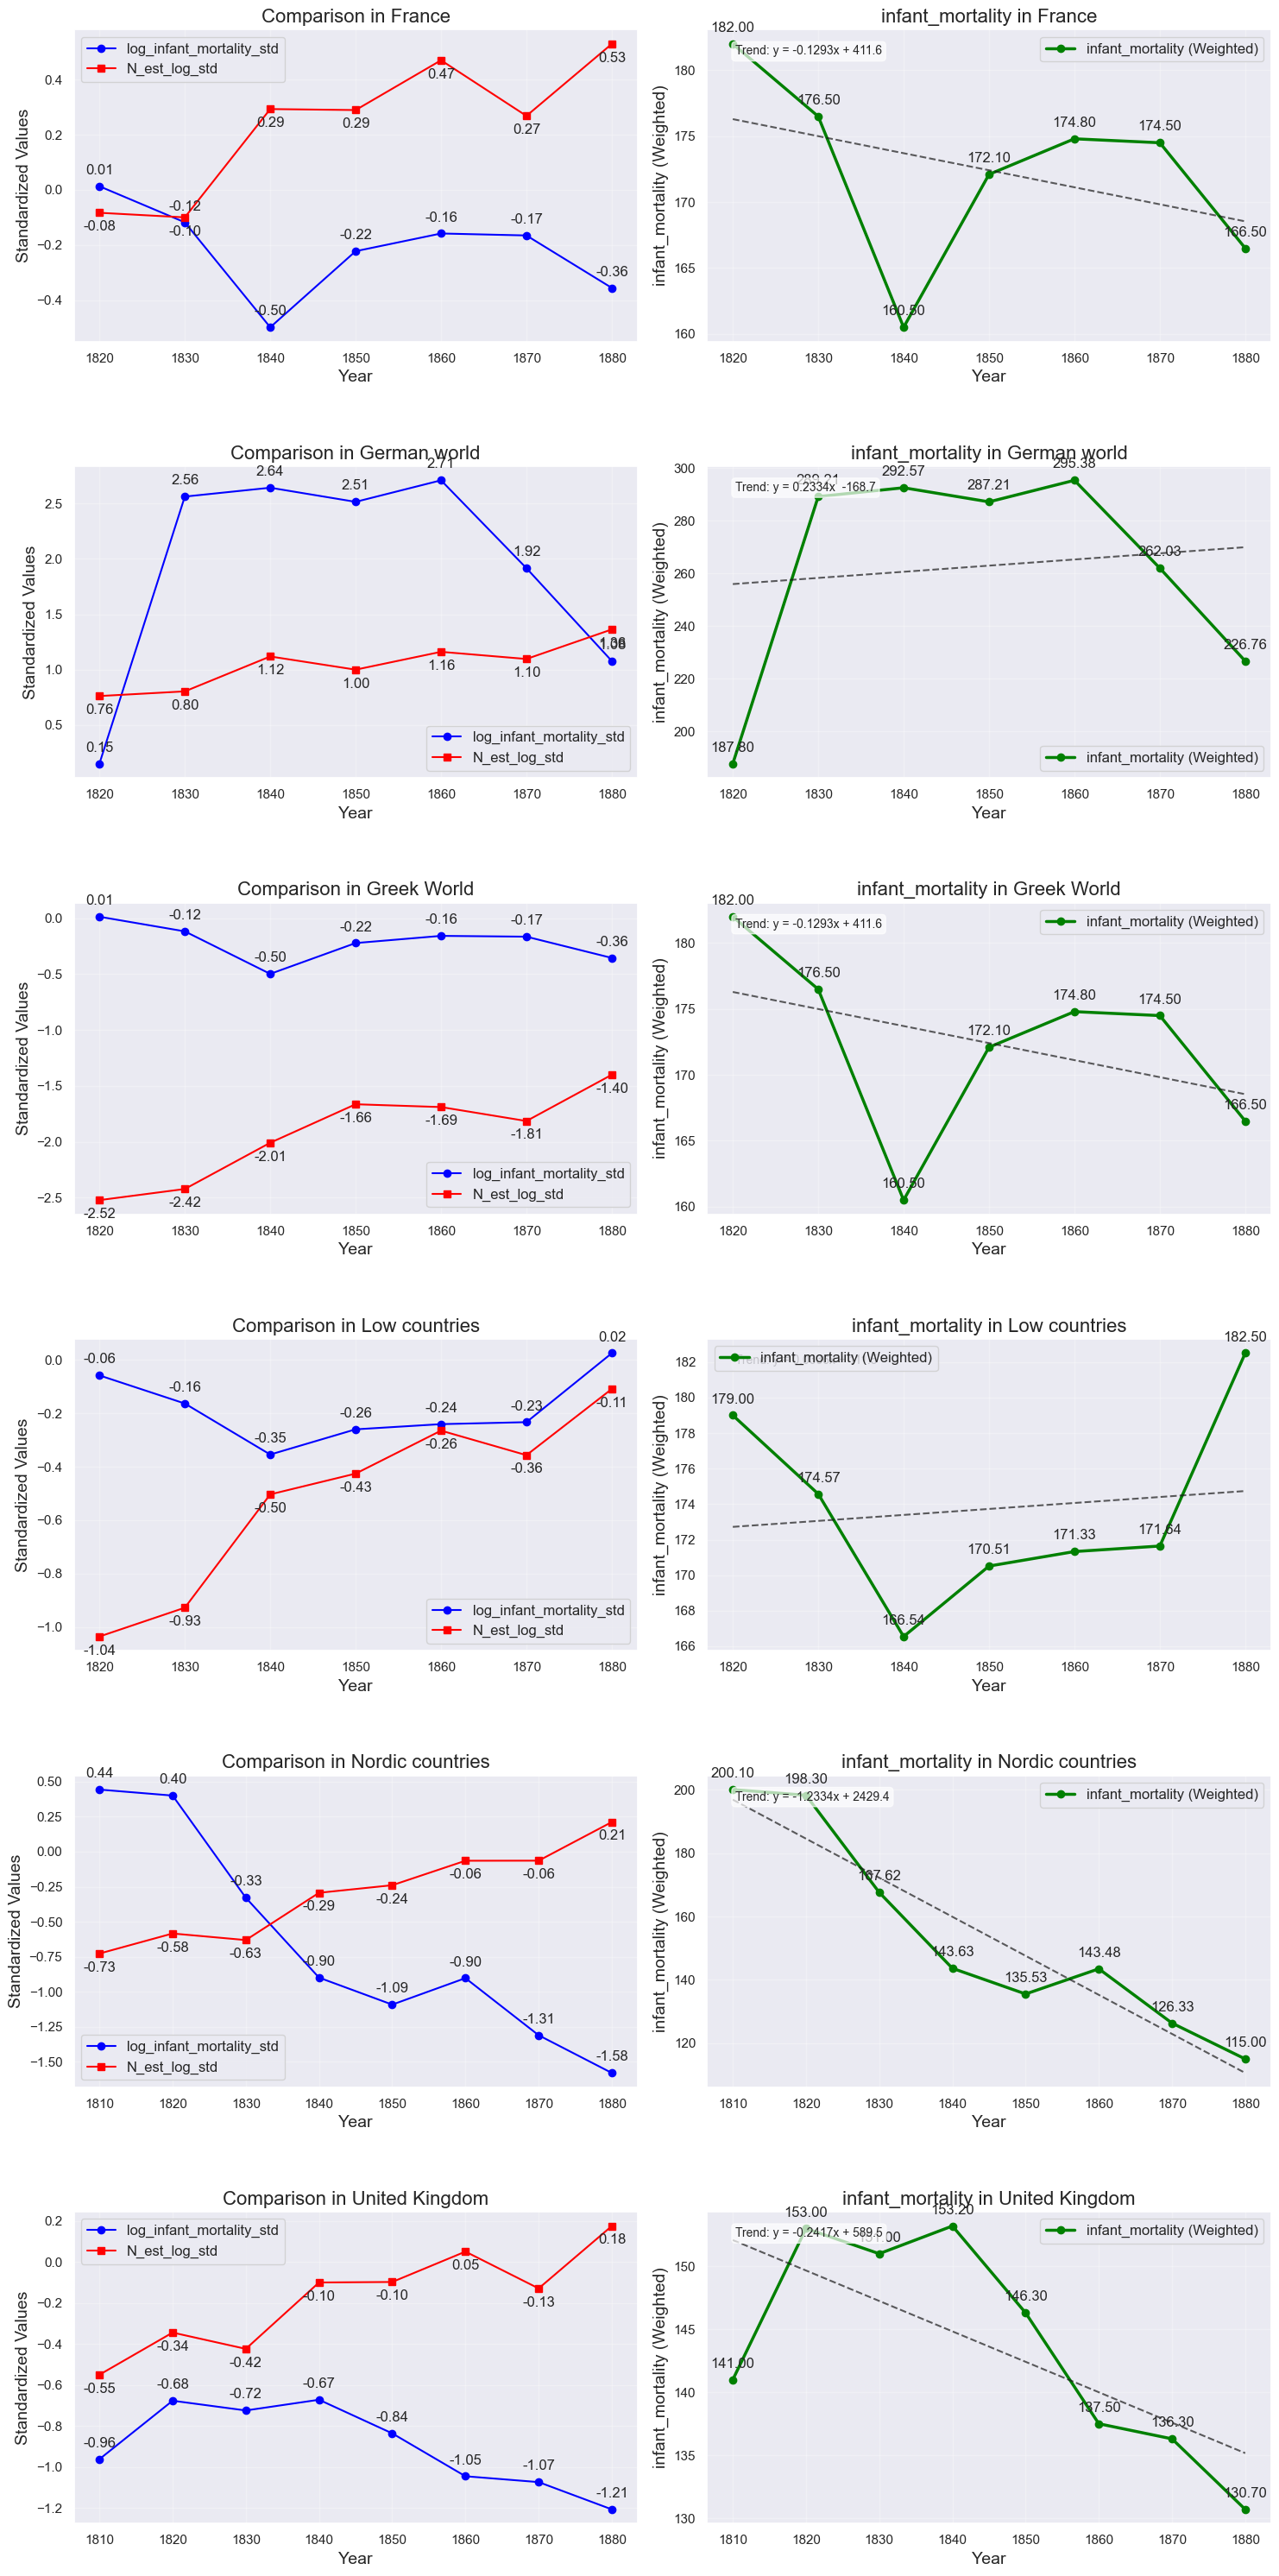

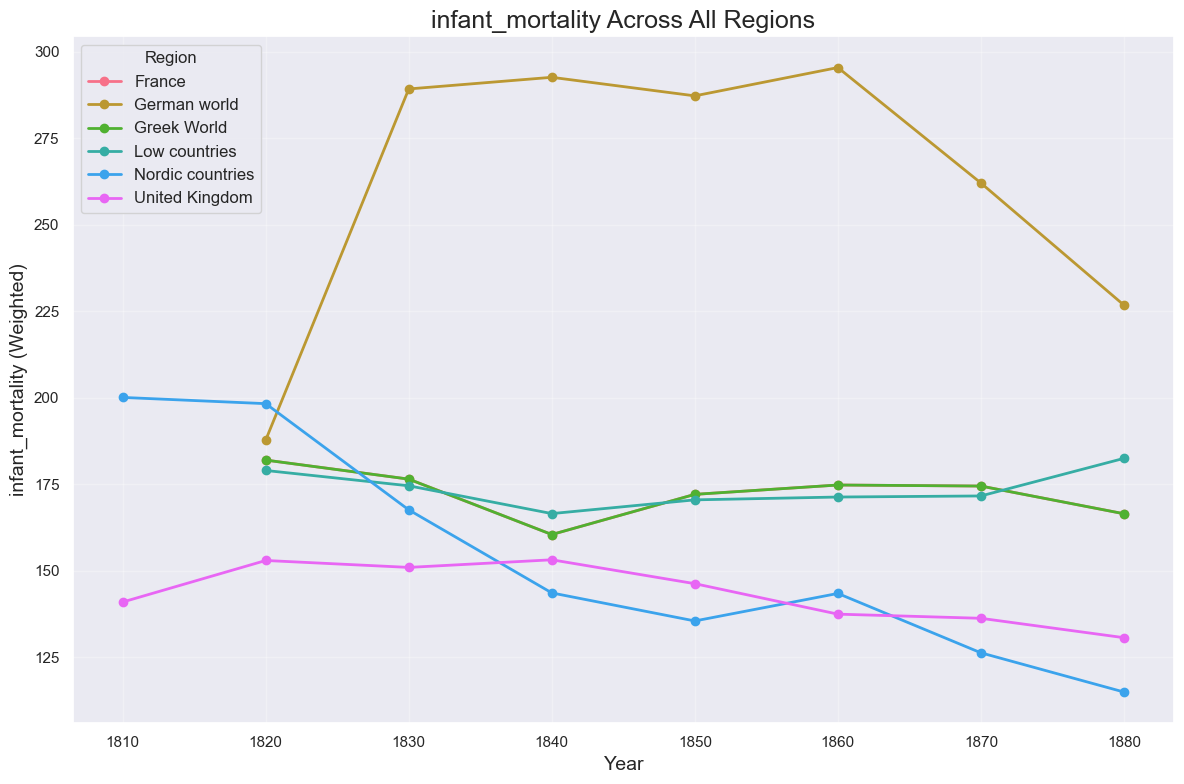

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_sample = df_ols.copy()

# Get all unique regions
regions = df_sample['region_name'].unique()

# Set the style for the plots
sns.set(style="darkgrid")

# Calculate the total number of subplots needed (2 per region: comparison + urbanization only)
total_plots = len(regions) * 2

# Create a figure with subplots arranged in pairs (one row per region, two columns)
fig, axes = plt.subplots(nrows=len(regions), ncols=2, figsize=(15, 5*len(regions)))

# If there's only one region, axes will need to be reshaped
if len(regions) == 1:
    axes = np.array([axes])

# Plot each region
for i, region in enumerate(regions):
    region_data = df_sample[df_sample['region_name'] == region]
    
    # Sort by year to ensure correct line plot
    region_data = region_data.sort_values('year')
    
    # Left plot (Column 0): Comparison of both metrics
    # Plot log_urbanization_std
    axes[i, 0].plot(region_data['year'], region_data[f'log_{var}_std'], 
                  marker='o', linestyle='-', color='blue', label=f'log_{var}_std')
    
    # Plot N_est_log_std on the same graph
    axes[i, 0].plot(region_data['year'], region_data['N_est_log_std'], 
                  marker='s', linestyle='-', color='red', label='N_est_log_std')
    
    # Set title and labels for comparison plot
    axes[i, 0].set_title(f'Comparison in {region}', fontsize=16)
    axes[i, 0].set_xlabel('Year', fontsize=14)
    axes[i, 0].set_ylabel('Standardized Values', fontsize=14)
    axes[i, 0].legend(fontsize=12)
    
    # Add grid for better readability
    axes[i, 0].grid(True, alpha=0.3)
    
    # Add data labels for comparison plot
    for x, y1, y2 in zip(region_data['year'], 
                         region_data[f'log_{var}_std'], 
                         region_data['N_est_log_std']):
        axes[i, 0].annotate(f'{y1:.2f}', (x, y1), textcoords="offset points", 
                          xytext=(0,10), ha='center')
        axes[i, 0].annotate(f'{y2:.2f}', (x, y2), textcoords="offset points", 
                          xytext=(0,-15), ha='center')
    
    # Right plot (Column 1): Urbanization only
    # Check if urbanization_weighted exists, otherwise use log_urbanization_std
    if f'{var}_weighted' in region_data.columns:
        y_values = region_data[f'{var}_weighted']
        y_label = f'{var} (Weighted)'
    else:
        y_values = region_data[f'log_{var}_std']
        y_label = f'{var} (Standardized, Log)'
    
    # Plot urbanization only
    axes[i, 1].plot(region_data['year'], y_values, 
                  marker='o', linestyle='-', linewidth=2.5, 
                  color='green', label=y_label)
    
    # Set title and labels for urbanization-only plot
    axes[i, 1].set_title(f'{var} in {region}', fontsize=16)
    axes[i, 1].set_xlabel('Year', fontsize=14)
    axes[i, 1].set_ylabel(y_label, fontsize=14)
    axes[i, 1].legend(fontsize=12)
    
    # Add grid for better readability
    axes[i, 1].grid(True, alpha=0.3)
    
    # Add data labels for urbanization-only plot
    for x, y in zip(region_data['year'], y_values):
        axes[i, 1].annotate(f'{y:.2f}', (x, y), textcoords="offset points", 
                          xytext=(0,10), ha='center')
    
    # Add trend line (linear regression) if we have enough points
    if len(region_data) > 1:
        z = np.polyfit(region_data['year'], y_values, 1)
        p = np.poly1d(z)
        trend_line = axes[i, 1].plot(region_data['year'], p(region_data['year']), 
                                   "k--", alpha=0.7)
        # Add trend equation
        slope = z[0]
        intercept = z[1]
        equation = f"Trend: y = {slope:.4f}x {'+' if intercept >= 0 else ''} {intercept:.1f}"
        axes[i, 1].text(0.05, 0.95, equation, transform=axes[i, 1].transAxes, 
                       fontsize=10, verticalalignment='top', 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Increase space between rows
plt.show()

# Optional: Create an additional figure showing urbanization for all regions together
plt.figure(figsize=(12, 8))
palette = sns.color_palette("husl", len(regions))

for i, region in enumerate(regions):
    region_data = df_sample[df_sample['region_name'] == region]
    region_data = region_data.sort_values('year')
    
    # Check if urbanization_weighted exists, otherwise use log_urbanization_std
    if f'{var}_weighted' in region_data.columns:
        y_values = region_data[f'{var}_weighted']
        y_label = f'{var} (Weighted)'
    else:
        y_values = region_data[f'log_{var}_std']
        y_label = f'{var} (Standardized, Log)'
    
    plt.plot(region_data['year'], y_values, 
             marker='o', linestyle='-', linewidth=2, 
             color=palette[i], label=region)

plt.title(f'{var} Across All Regions', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel(y_label, fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Region', fontsize=12)
plt.tight_layout()
plt.show()

In [72]:
df_var

,ccode,year,infant_mortality,country_name,iso_a3,region
0,152,1900,314.50,Chile,CHL,South America
1,152,1910,206.00,Chile,CHL,South America
2,152,1930,175.30,Chile,CHL,South America
3,152,1920,173.90,Chile,CHL,South America
4,152,1940,170.80,Chile,CHL,South America
...,...,...,...,...,...,...
1625,414,1990,12.67,Kuwait,KWT,Arabic world
1626,414,1990,12.67,Kuwait,KWT,Muslim world
1627,414,1990,12.67,Kuwait,KWT,Ottoman world
1628,428,1940,7.60,Latvia,LVA,Central Europe


<Axes: xlabel='year'>

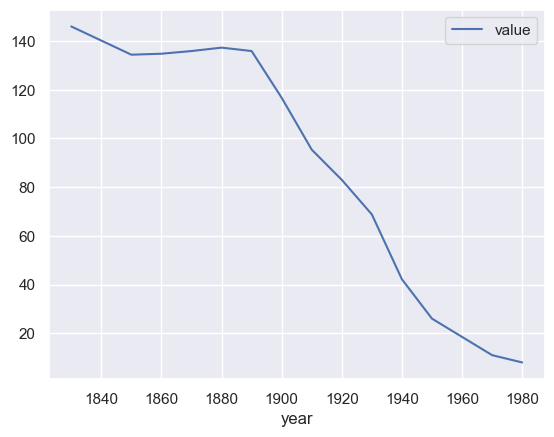

In [73]:
# UK, Germany, Spain, France

df_var = pd.read_excel(f'data/environment_data/{original_name}.xlsx', sheet_name='Data Long Format')
df_var[df_var['country.name']=='Denmark'].plot(x='year', y = 'value')
